# Imports required for training the model

In [1]:
import numpy as np                    # For maths, arrays, image manipulation
import matplotlib.pyplot as plt       # To visualize doodles/images
import json                           # For reading .ndjson/raw data files
import tensorflow as tf               # For deep learning (CNN)
import os                             # File system access - finding/loading files
from sklearn.model_selection import train_test_split   # For splitting data sets
from tensorflow.keras import layers, models


# Here is the sample dataset!
Example for cat

In [2]:
# Download one category (e.g. 'cat') as example
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cat.npy

--2025-08-29 12:48:48--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cat.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.0.91, 172.217.12.27, 172.217.15.251, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.0.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96590448 (92M) [application/octet-stream]
Saving to: ‘cat.npy’

cat.npy             100%[===================>]  92.12M   101MB/s    in 0.9s    

2025-08-29 12:48:49 (101 MB/s) - ‘cat.npy’ saved [96590448/96590448]



Cat image array shape: (123202, 784)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


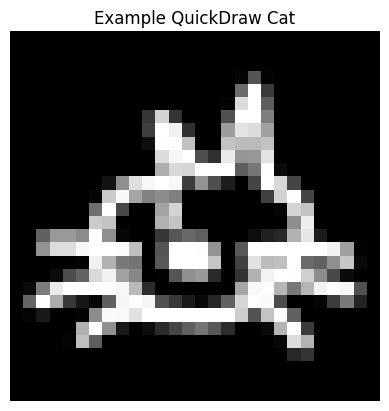

In [3]:
cat_images = np.load('cat.npy')
print("Cat image array shape:", cat_images.shape)  # Should be (num_samples, 784)
print(cat_images[:30])

# Visualize
plt.imshow(cat_images[0].reshape(28,28), cmap='gray')
plt.title("Example QuickDraw Cat")
plt.axis('off')
plt.show()


# Data - prep
We’ll train on 10 categories for speed

In [17]:
categories = ["cat", "dog", "tree", "car", "cloud",
              "house", "star", "airplane", "rainbow", "chair"]


# Map category names to numbers
label_map = {cat: idx for idx, cat in enumerate(categories)}
print(label_map)

Created 'labels.txt' successfully.

File content:
cat
dog
tree
car
cloud
house
star
airplane
rainbow
chair


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

{'cat': 0, 'dog': 1, 'tree': 2, 'car': 3, 'cloud': 4, 'house': 5, 'star': 6, 'airplane': 7, 'rainbow': 8, 'chair': 9}


Download & Load

In [5]:
all_images = []
all_labels = []

for category in categories:
    url = f"https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy"
    filename = f"{category}.npy"

    # Download only if not already there
    if not os.path.exists(filename):
        !wget $url -O $filename

    # Load numpy array
    images = np.load(filename)

    # Normalize pixel values [0,255] → [0,1]
    images = images.astype("float32") / 255.0

    # Limit samples for speed
    n_samples = 10000
    all_images.append(images[:n_samples])
    all_labels.append(np.full(n_samples, label_map[category]))

    print(f"{category}: {images.shape[0]} total, using {n_samples}")


cat: 123202 total, using 10000
--2025-08-29 12:49:35--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/dog.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.0.91, 172.217.12.27, 172.217.15.251, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.0.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119292736 (114M) [application/octet-stream]
Saving to: ‘dog.npy’

dog.npy             100%[===================>] 113.77M   241MB/s    in 0.5s    

2025-08-29 12:49:36 (241 MB/s) - ‘dog.npy’ saved [119292736/119292736]

dog: 152159 total, using 10000
--2025-08-29 12:49:36--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/tree.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.0.91, 172.217.12.27, 172.217.15.251, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.0.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 

Combine and reshape

In [6]:
# Combine into one dataset
X = np.concatenate(all_images, axis=0)
y = np.concatenate(all_labels, axis=0)

print("Final dataset shape:", X.shape, y.shape)

# Reshape to (28,28,1) for CNN input
X = X.reshape(-1, 28, 28, 1)

print("Reshaped dataset:", X.shape)


Final dataset shape: (100000, 784) (100000,)
Reshaped dataset: (100000, 28, 28, 1)


Train/Test Split

In [7]:
# Split train/test (stratify = keep class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)


Train set: (80000, 28, 28, 1) (80000,)
Test set: (20000, 28, 28, 1) (20000,)


Visualize Dataset

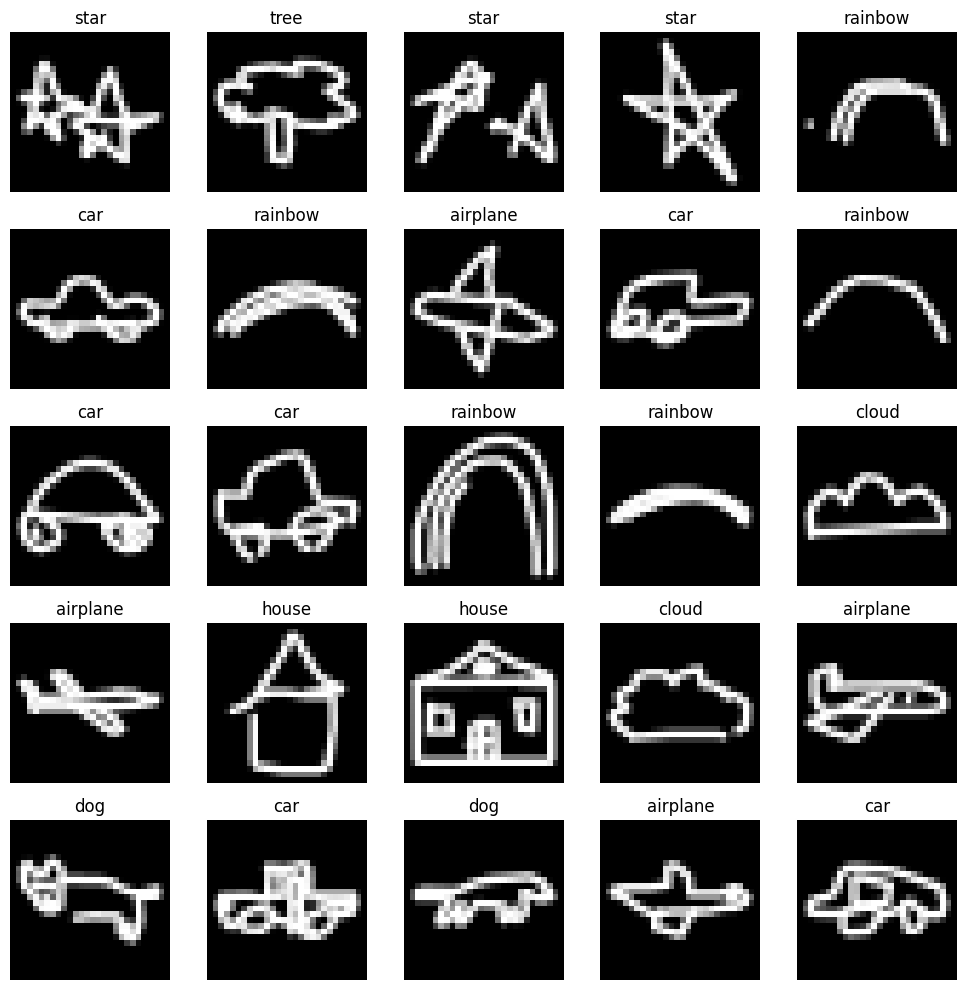

In [9]:
# Pick 25 random samples to visualize
plt.figure(figsize=(10, 10))
for i in range(25):
    idx = np.random.randint(0, len(X))
    plt.subplot(5, 5, i+1)
    plt.imshow(X[idx].reshape(28, 28), cmap="gray")
    plt.title(categories[y[idx]])
    plt.axis("off")
plt.tight_layout()
plt.show()

# Basic CNN Model

In [10]:
from tensorflow.keras import layers, models

# Define CNN with 3 convolutional layers
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(28,28,1)), #learns edges, lines, corners (low-level features).
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation="relu"), #combines them into shapes/patterns (loops, strokes).
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation="relu"), #more abstract features (e.g. “cat ear”, “wheel”, “star point”).
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(len(categories), activation="softmax")  # output layer
])

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,266 (501.04 KB)

 Trainable params: 128,266 (501.04 KB)

 Non-trainable params: 0 (0.00 B)

# Transfer learning + data augumentation

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras import layers, models

# X_train_rgb = tf.image.grayscale_to_rgb(tf.constant(X_train)).numpy()
# X_test_rgb = tf.image.grayscale_to_rgb(tf.constant(X_test)).numpy()

# IMG_SIZE = 75
# X_train_resized = tf.image.resize(X_train_rgb, (IMG_SIZE, IMG_SIZE)).numpy()
# X_test_resized = tf.image.resize(X_test_rgb, (IMG_SIZE, IMG_SIZE)).numpy()

# print("Original training data shape:", X_train.shape)
# print("New resized training data shape:", X_train_resized.shape)
# print("-" * 30)


# # --- 2. Build the Transfer Learning Model ---

# base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
#                          include_top=False,
#                          weights='imagenet')

# # Freeze the convolutional base to prevent its weights from changing during training.
# base_model.trainable = False

# transfer_model = models.Sequential([
#     base_model,
#     layers.GlobalAveragePooling2D(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(len(categories), activation='softmax')  # Our output layer
# ])

# # Compile the model.
# transfer_model.compile(optimizer="adam",
#                        loss="sparse_categorical_crossentropy",
#                        metrics=["accuracy"])

# transfer_model.summary()

In [ ]:
# This can be used to augument the image data addded to the model.fit!


#from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Create an ImageDataGenerator for data augmentation
# datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=False, # Not always useful for doodles, but good to know
#     fill_mode='nearest'
# )

# Train the model

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 72s 107ms/step - accuracy: 0.6198 - loss: 1.1233 - val_accuracy: 0.8653 - val_loss: 0.4275
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 123ms/step - accuracy: 0.8608 - loss: 0.4378 - val_accuracy: 0.8862 - val_loss: 0.3482
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 128ms/step - accuracy: 0.8896 - loss: 0.3414 - val_accuracy: 0.8993 - val_loss: 0.3022
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 68s 106ms/step - accuracy: 0.9054 - loss: 0.2912 - val_accuracy: 0.9082 - val_loss: 0.2746
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 68s 109ms/step - accuracy: 0.9162 - loss: 0.2571 - val_accuracy: 0.9136 - val_loss: 0.2629
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 84s 134ms/step - accuracy: 0.9229 - loss: 0.2326 - val_accuracy: 0.9112 - val_loss: 0.2708
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 138s 128ms/step - accuracy: 0.9299 - loss: 0.2116 - val_accuracy: 0.9125 - val_loss: 0.2739
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 123ms/step - accuracy: 0.9358 - loss: 

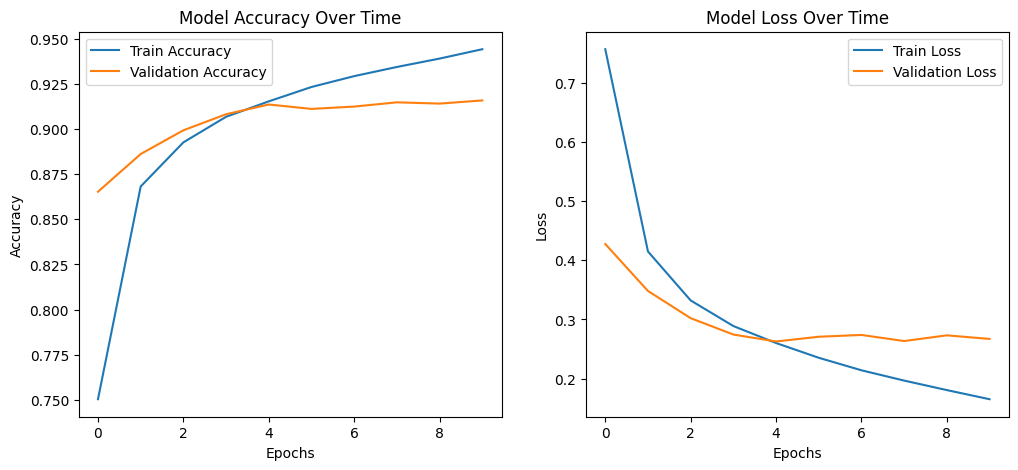

In [11]:
history = model.fit(
    X_train, y_train,
    epochs=10,               # enough to see improvement but not too long in class
    batch_size=128,          # process 128 doodles at a time
    validation_data=(X_test, y_test)
)

# Transfer learning

# history = transfer_model.fit(
#     datagen.flow(X_train, y_train, batch_size=128), # transfer learning  + data augumentation!
#     epochs=20,
#     validation_data=(X_test_resized, y_test)
# )

# Plot accuracy and loss over time
plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Over Time")
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss Over Time")
plt.legend()

plt.show()

Evaluate & Test Predictions

Test Accuracy: 91.59%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


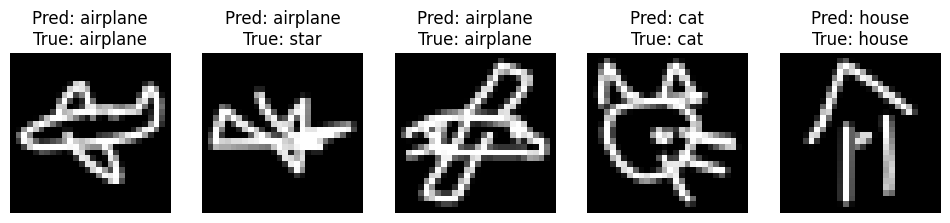

In [15]:
# Evaluate on test set
class_names = categories
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Make predictions on a few random samples
import random

# Pick 5 random test images
indices = random.sample(range(len(X_test)), 5)

plt.figure(figsize=(12,3))
for i, idx in enumerate(indices):
    img = X_test[idx].reshape(28,28)
    label = y_test[idx]
    pred = np.argmax(model.predict(X_test[idx].reshape(1,28,28,1)))

    plt.subplot(1,5,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {class_names[pred]}\nTrue: {class_names[label]}")
    plt.axis('off')
plt.show()


# Sample Testing live

In [ ]:
import gradio as gr

def predict_doodle(img):
    if img is None:
        return "Please draw something!"
    # If input is dict, use 'composite' image
    if isinstance(img, dict):
        img = img.get("composite", None)
    if img is None:
        return "Please draw something!"
    # Convert the composite PIL Image to grayscale numpy array (already L mode)
    img = np.array(img)
    # Resize to 28x28 and normalize
    img = tf.image.resize(img[..., np.newaxis], (28, 28)).numpy()
    img = img / 255.0
    # Predict probabilities once
    preds = model.predict(img.reshape(1, 28, 28, 1))[0]
    # Return label with highest probability
    pred_label = class_names[np.argmax(preds)]
    return pred_label


interface = gr.Interface(
    fn=predict_doodle,
    inputs=gr.Sketchpad(type="pil", image_mode="L"),
    outputs="label",
    live=True,
)
interface.launch(share=True, debug=True)

# Export the model

Tf lite export for mobile apps!

In [16]:
import tensorflow as tf

# Create a TFLiteConverter object from the Keras model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Optimizee
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# 3. Convert the model.
tflite_model = converter.convert()

# 4. Save the converted model to a .tflite file.
with open('doodle_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Successfully converted model to 'doodle_model.tflite'")
print(f"File size: {len(tflite_model) / 1024:.2f} KB")

# 5. Download the file from Colab to your local machine.
from google.colab import files
files.download('doodle_model.tflite')

Saved artifact at '/tmp/tmptjjs4tz4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132038538416720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132038538417488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132038538419600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132038538418256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132038538419024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132038538420368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132038538416912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132038538418640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132038538420176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132038538421328: TensorSpec(shape=(), dtype=tf.resource, name=None)
Successfully conv

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tf js export for web apps

In [ ]:
!pip install tensorflowjs

import tensorflowjs as tfjs

# Define the path where you want to save the model
output_path = 'doodle_model_js'

# Convert the Keras model (use 'model' or 'transfer_model')
tfjs.converters.save_keras_model(model, output_path)

print(f"Model saved for TensorFlow.js in the '{output_path}' directory.")

# To download, first zip the directory, then download the zip file.
!zip -r {output_path}.zip {output_path}

from google.colab import files
files.download(f'{output_path}.zip')

# NOTE: It creates a directory named doodle_model_js containing a model.json file (the model architecture) and several .bin files (the weights) these bin are named like shards.smtg1.bin, etc.